# The Linear Quadratic Regulator

## Control History

## LQR Problem

$$
\min_{x_{1:N}, u_{1:N-1}} J=\sum_{k=1}^{N-1} ( \frac{1}{2} x_k^{\intercal} Q_k x_k + \frac{1}{2} u_k^{\intercal} R_k u_k )+ \frac{1}{2} x_N^{\intercal} Q_N x_N
\\
\\
\text { s.t. } x_{k+1} =A_k x_k+B_k u_k \\
Q \succeq 0, R 	\succ 0
$$

Where $x_k^{\intercal} Q_k x_k$ is the state cost, $u_k^{\intercal} R_k u_k$ is the control cost and $x_N^{\intercal} Q_N x_N$ is the terminal cost. $Q_k$ must be positive semi-definite and $R_k$ strictly positive definite.

LQR formulation can (locally) approximate many non-linear problems.

It is computationally tractable

There are many extensions to this such as infinite horizon, stochastic etc.

It is "time invariant" if $A_k = A$, $B_k = B$ and $Q_k = Q$, $R_k = R$ $\forall t$.

## Solving LQR - Indirect Shooting
Plugging the cost and dynamics into Pontryagin's Principle we have.

$$
\begin{aligned}
x_{k+1} & =\nabla_\lambda H\left(x_k, u_k, \lambda_{k+1}\right)=A x_k+B u_k \\
\lambda_k & =\nabla_x H\left(x_k, u_k, \lambda_{k+1}\right)=Q x_k+A^{\intercal} \lambda_{k+1} \\
\lambda_N & =Q_N x_N \\
u_k & =\operatorname{argmin}_{\bar{u}} H\left(x_k, \bar{u}, \lambda_{k+1}\right) \\
& =-R^{-1} B^{\intercal} \lambda_{k+1}
\end{aligned}
$$

Algorithm

1. Start with inital $U_{1:N-1}$
1. Simulate ("rollout") to get $X_{1:N}$
1. Backward pass to get $\lambda$ and $\Delta u$
1. Rollout with line search on $\Delta u$
1. Go to 3. until convergence.

### Example: Double Integrator

Dynamics of a frictionless cart could be given by

$$
\dot{x}=\left[\begin{array}{c}
\dot{q} \\
\ddot{q}
\end{array}\right]=\left[\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right]\left[\begin{array}{l}
q \\
\dot{q}
\end{array}\right] = \left[\begin{array}{l}
0 \\
1
\end{array}\right]
$$

Discretizing this with Forward Euler gives


$$
x_{k+1}=\left[\begin{array}{ll}
1 & h \\
0 & 1
\end{array}\right]\left[\begin{array}{c}
q_k \\
\dot{q}_k
\end{array}\right]+\left[\begin{array}{c}
\frac{1}{2} h^2 \\
h
\end{array}\right] u_k
$$

In [5]:
import Pkg; Pkg.activate(@__DIR__);
using LinearAlgebra
using Plots

  Activating project at `/workspaces/CMU-16-745/optimalcontrol`


In [6]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

n = 2     # number of state
m = 1     # number of controls
Tfinal = 5.0 # final time #try larger values
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

# Initial conditions
x0 = [1.0; 0]

# Cost weights
Q = 1.0*I(2)
R = 0.1
Qn = 1.0*I(2)

function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*uhist[k]'*R*uhist[k]
    end
    return cost
end

function rollout(xhist, uhist)
    xnew = zeros(size(xhist))
    xnew[:,1] = xhist[:,1]
    for k = 1:(N-1)
        xnew[:,k+1] .= A*xnew[:,k] + B*uhist[k]
    end
    return xnew
end

rollout (generic function with 1 method)

In [7]:
# Initial guess
xhist = repeat(x0, 1, N)
uhist = zeros(N-1)
Δu = ones(N-1)
λhist = zeros(n,N)

xhist = rollout(xhist, uhist) #initial rollout to get state trajectory

J(xhist,uhist) #Initial cost



25.5

In [8]:
b = 1e-2 #line search tolerance
α = 1.0
iter = 0
while maximum(abs.(Δu[:])) > 1e-2 #terminate when the gradient is small
    
    #Backward pass to compute λ and Δu
    λhist[:,N] .= Qn*xhist[:,N]
    for k = N-1:-1:1
        Δu[k] = -(uhist[k]+R\B'*λhist[:,k+1])
        λhist[:,k] .= Q*xhist[:,k] + A'*λhist[:,k+1]
    end
    
    #Forward pass with line search to compute x
    α = 1.0
    unew = uhist + α.*Δu
    xnew = rollout(xhist, unew)
    while J(xnew, unew) > J(xhist, uhist) - b*α*Δu[:]'*Δu[:]
        α = 0.5*α
        unew = uhist + α.*Δu
        xnew = rollout(xhist, unew)
    end
    uhist .= unew;
    xhist .= xnew;
    iter += 1
end

@show iter
@show J(xhist, uhist)


iter = 664
J(xhist, uhist) = 6.658144576322122


6.658144576322122

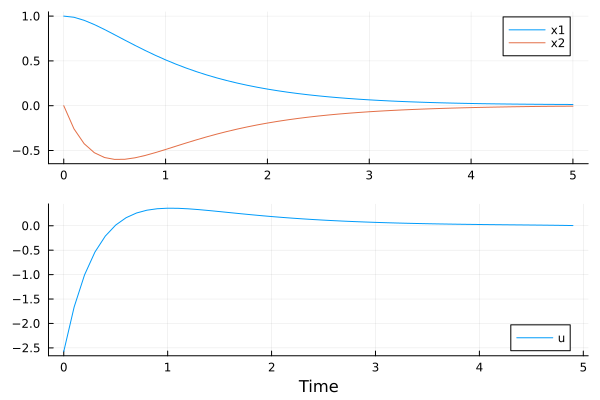

In [28]:

# Plot
l = @layout [a ; b]
p1 = plot(thist, xhist', label=["x1" "x2"])
p2 = plot(thist[1:end-1], uhist, label="u", xlabel="Time")
plot(p1, p2, layout = l)

## Solving LQR - As a QP

## Solving LQR - Riccati Recursion